<a href="https://colab.research.google.com/github/Geekomaniac1009/PCR_Trading_Strategy/blob/main/QuantKriti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import relativedelta
import time


def pnl_ratio(signals, share_ratio, sale_ratio):

    initial_cap = 100000
    portfolio = pd.DataFrame()
    portfolio['position'] = signals['position']
    portfolio['holdings'] = 0
    portfolio['shares'] = 0
    portfolio['cash'] = 0
    portfolio['total'] = 0
    for idx in range(len(signals)):

        #buy posn
        if signals['position'][idx] == 1:
            shares = initial_cap*share_ratio // signals['Close'][idx]
            initial_cap = initial_cap - shares*signals['Close'][idx]
            if idx != 0:
                portfolio['shares'][idx] = portfolio['shares'][idx-1] + shares
            else:
                portfolio['shares'][idx] = shares

        #sell posn
        elif signals['position'][idx] == -1 and idx != 0:
            num_shares = portfolio['shares'][idx-1]*sale_ratio
            if num_shares <= portfolio['shares'][idx-1]:
                initial_cap = initial_cap + num_shares*signals['Close'][idx]
                portfolio['shares'][idx] = portfolio['shares'][idx-1] - num_shares


        elif signals['position'][idx] == 0 and idx != 0:
            portfolio['shares'][idx] = portfolio['shares'][idx-1]

        portfolio['cash'][idx] = initial_cap
        portfolio['holdings'][idx] = portfolio['shares'][idx]*signals['Close'][idx]
        portfolio['total'][idx] = portfolio['cash'][idx] + portfolio['holdings'][idx]
    portfolio['returns'] = portfolio['total'].pct_change()
    percent_return = (portfolio['total'][len(signals)-1] - 100000)/100000 * 100
    plt.figsize=(10,6)
    plt.plot(portfolio['total'])
    plt.title('Total Portfolio Value')
    plt.legend()
    plt.show()
    return portfolio, percent_return

In [ ]:
def annualised_sharpe_ratio(portfolio, benchmark_portfolio):
    mean  = np.mean(portfolio['returns']-benchmark_portfolio['returns'])
    std_dev = np.std(portfolio['returns']-benchmark_portfolio['returns'])
    sharpe = (mean) / (std_dev)* np.sqrt(252)
    return sharpe

In [ ]:
def beta(portfolio, benchmark):
    covariance = np.cov(portfolio['returns'][1:], benchmark['returns'][1:])
    beta = covariance[0,1]/ np.var(benchmark['returns'])
    return beta

In [ ]:
def alpha(percent_change, portfolio, benchmark, benchmark_pct_change, risk_free_rate):

    be = beta(portfolio, benchmark)
    alpha = percent_change - risk_free_rate - be * (benchmark_pct_change - risk_free_rate)
    return alpha

In [ ]:
def sortino_ratio(portfolio, benchmark_portfolio, risk_free_rate):
    mean  = np.mean(portfolio['returns']-benchmark_portfolio['returns'])

    downside_returns = portfolio['returns'].copy()
    downside_returns[downside_returns > 0] = 0
    downside_std_dev = downside_returns.std()
    sortino = (mean - risk_free_rate) / downside_std_dev * np.sqrt(252)
    return sortino

In [ ]:
def max_drawdown(portfolio):
    window = len(portfolio)
    rolling_max = portfolio['total'].rolling(window, min_periods=1).max()
    daily_drawdown = portfolio['total']/rolling_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
    return max_daily_drawdown.min()

In [ ]:
def calmar_ratio(portfolio):
    avg_return = np.mean(portfolio['returns'])
    max_draw = max_drawdown(portfolio)
    calmar = avg_return / abs(max_draw)
    return calmar

In [ ]:
def win_rate(portfolio):
    win_rate = (portfolio['returns'] > 0).sum() / len(portfolio['returns'])
    return win_rate

In [ ]:
def benchmark_strategy(data):
    signals = pd.DataFrame()
    signals['Close'] = data['Close']
    signals['Open'] = data['Open']
    signals['position'] = 0
    for idx in range(len(data)):
        if idx == 0:
            signals['position'][idx] = 1
        else:
            signals['position'][idx] = 0
    return signals

In [ ]:
data = pd.read_csv('index_data.csv', na_values=['-'])
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

data['High'] = data['High'].interpolate(method='linear', limit_direction='forward')
data['Low'] = data['Low'].interpolate(method='linear', limit_direction='forward')
data['Close'] = data['Close'].interpolate(method='linear', limit_direction='forward')
data['Open'] = data['Open'].interpolate(method='linear', limit_direction='forward')



for i in range(len(data)):
    date_obj = datetime.strptime(data['Date'][i], '%Y-%m-%d')
    reversed_date = date_obj.strftime('%d-%b-%Y')
    data['Date'][i] = reversed_date


<ipython-input-43-79723041bba6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'][i] = reversed_date


In [ ]:
def pivot_pcr_strategy(data, put_option, call_option):
    signals = pd.DataFrame()
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    signals['Close'] = data['Close']
    signals['Open'] = data['Open']
    signals['position'] = 0
    data['Pivot'] = (data['High'] + data['Low'] + data['Close'])/3
    entry_point = 0
    signals['PCR'] = 0


    for idx in range(len(data)):
        val = put_option['Underlying Value'][idx]
        df = put_option[put_option['Date'] == data['Date'][idx]]
        df2 = call_option[call_option['Date'] == data['Date'][idx]]
        reset_df = df.reset_index(drop = True)
        reset_df2 = df2.reset_index(drop = True)

        for j in range(1, 78):
            if abs(reset_df['Strike Price'][j] - val) > abs(reset_df['Strike Price'][j-1] - val) and reset_df2['Open Interest'][j-1] != 0:
                signals['PCR'][idx] = reset_df['Open Interest'][j-1] / reset_df2['Open Interest'][j-1]




    for idx in range(len(data)):
        if (data['Close'][idx] > data['Pivot'][idx]) and (signals['PCR'][idx] < 0.7):
            signals['position'][idx] = 1
            entry_point = data['Close'][idx]
        elif (data['Close'][idx] > entry_point and entry_point != 0 and signals['PCR'][idx] > 1):
            signals['position'][idx] = -1

    # Set stop loss at the low of the entry candle
    data['StopLoss'] = data['Low'].shift(1)
    plt.figsize=(10,5)
    plt.plot(data['Close'], label='Close Price', alpha = 0.5)
    plt.plot(data['Pivot'], label='Pivot', alpha = 0.5)
    plt.plot(signals['position'][signals['position'] == 1].index, signals['Close'][signals['position'] == 1], '^', markersize=5, color='g', label = 'Buy Signal')
    plt.plot(signals['position'][signals['position'] == -1].index, signals['Close'][signals['position'] == -1], 'v', markersize=5, color='r', label = 'Sell Signal')
    plt.legend()
    plt.show()
    return signals


<ipython-input-45-6ab7c02c198f>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  put_option = pd.read_csv('put_option_data.csv', na_values=['-'], on_bad_lines='skip')
<ipython-input-44-3c4f72ae2a80>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['PCR'][idx] = reset_df['Open Interest'][j-1] / reset_df2['Open Interest'][j-1]
<ipython-input-44-3c4f72ae2a80>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['position'][idx] = 1
<ipython-input-44-3c4f72ae2a80>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

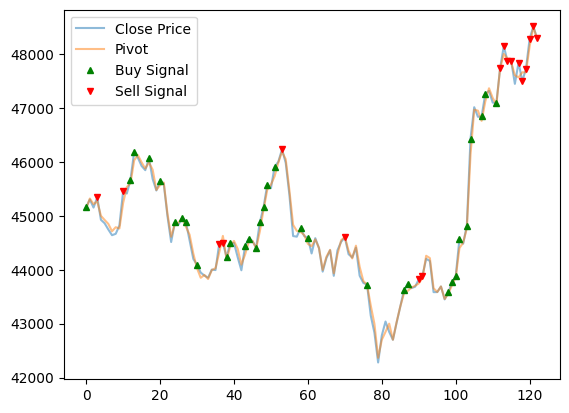

<ipython-input-34-3da940fa4c82>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['holdings'][idx] = portfolio['shares'][idx]*signals['Close'][idx]
<ipython-input-34-3da940fa4c82>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['total'][idx] = portfolio['cash'][idx] + portfolio['holdings'][idx]
<ipython-input-34-3da940fa4c82>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['shares'][idx] = portfolio['s

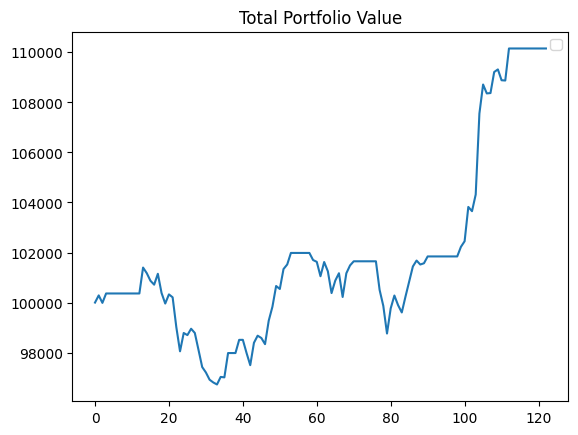

10.15309375

In [ ]:
put_option = pd.read_csv('put_option_data.csv', na_values=['-'], on_bad_lines='skip')
call_option = pd.read_csv('call_option_data.csv', na_values=['-'], on_bad_lines='skip')
put_option.columns = ['Date', 'Expiry', 'Option Type', 'Strike Price', 'Open', 'High', 'Low', 'Close', 'No. of Contracts', 'Open Interest', 'Change in OI', 'Underlying Value']
call_option.columns = ['Date', 'Expiry', 'Option Type', 'Strike Price', 'Open', 'High', 'Low', 'Close', 'No. of Contracts', 'Open Interest', 'Change in OI', 'Underlying Value']
signal = pd.DataFrame()


avg_1 = put_option['Open Interest'].mean()
avg_2 = call_option['Open Interest'].mean()
put_option['Open Interest'].fillna(int(avg_1), inplace=True)
call_option['Open Interest'].fillna(int(avg_2), inplace=True)
signal = pivot_pcr_strategy(data, put_option, call_option)
portfolio, pct_change = pnl_ratio(signal, 1, 1)

signal
pct_change


<ipython-input-42-69a3a0296dfc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['position'][idx] = 1
<ipython-input-42-69a3a0296dfc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['position'][idx] = 0
<ipython-input-34-3da940fa4c82>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['holdings'][idx] = portfolio['shares'][idx]*signals['Close'][idx]
<ipython-input-34-3da940fa4c82>:42: SettingWithCopyWarning: 

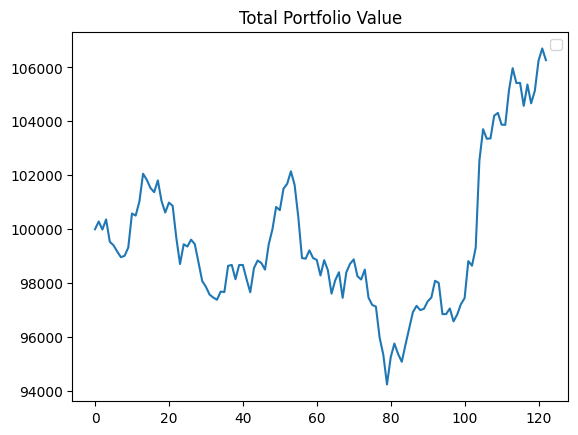

6.268296875

In [ ]:
benchmark_signal = pd.DataFrame()
benchmark_signal = benchmark_strategy(data)
benchmark_portfolio, bmk_pct_change = pnl_ratio(benchmark_signal, 1, 0)
benchmark_portfolio
bmk_pct_change

In [ ]:
annualised_sharpe_ratio(portfolio, benchmark_portfolio)

1.2924007878315351

In [ ]:
beta(portfolio, benchmark_portfolio)

0.702481542501523

In [ ]:
alpha(pct_change, portfolio, benchmark_portfolio, bmk_pct_change, 0)

5.749730892392524

In [ ]:
sortino_ratio(portfolio, benchmark_portfolio, 0)

1.7044625072794453

In [ ]:
max_drawdown(portfolio)

-0.04607249608888786